In [2]:
!pip install tensorflow
!pip install gpflow==2.9.1

import numpy as np
import gpflow
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 7.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import itertools

import gpflow
from gpflow.mean_functions import Constant
from gpflow.likelihoods import HeteroskedasticTFPConditional
import tensorflow as tf

In [6]:
import pandas as pd

In [43]:
# DEFINE HETEROSKEDASTIC GP MODEL + TRAINING
def train_noise_model(X, y):
    kernel = gpflow.kernels.SquaredExponential(lengthscales=0.1)
    noise_model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(noise_model.training_loss, noise_model.trainable_variables)
    return noise_model

# Expected Improvement function for minimization
def expected_improvement(y_best, f_mean, f_var):
    variance = np.maximum(f_var, 1e-9)  # Ensure variance is non-negative
    std_dev = np.sqrt(variance)
    delta = f_mean - y_best # f_mean - y_best for maximization
    with np.errstate(divide='ignore'):
        Z = delta / std_dev
        ei = delta * norm.cdf(Z) + std_dev * norm.pdf(Z)  # Correctly adjusted for minimization
        ei[std_dev == 0.0] = 0.0
    return ei

def train_heteroskedastic_gp_model(X, y, noise_variance):
    kernel = gpflow.kernels.SquaredExponential(lengthscales=0.3)
    heteroskedastic_gp_model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)

    # During predictions, incorporate the noise variance manually
    def custom_predict(X_new):
        mean, variance = heteroskedastic_gp_model.predict_f(X_new)

        # Ensure noise_variance is broadcasted correctly
        if noise_variance.shape[0] != X_new.shape[0]:
            expanded_noise_variance = tf.broadcast_to(noise_variance.mean(), variance.shape)
        else:
            expanded_noise_variance = tf.broadcast_to(noise_variance, variance.shape)

        # Add the expanded noise variance to the predicted variance
        variance = variance + expanded_noise_variance

        return mean, variance

    # Attach the custom predict method to the model
    heteroskedastic_gp_model.custom_predict = custom_predict

    # Train the model
    opt = gpflow.optimizers.Scipy()
    opt.minimize(
        heteroskedastic_gp_model.training_loss,
        heteroskedastic_gp_model.trainable_variables
    )

    return heteroskedastic_gp_model

In [46]:
# Load data from CSV
data = pd.read_csv('DOE2factor - DOE2factor_ALL.csv')
x1 = data['X1'].values.reshape(-1, 1)
x2 = data['X2'].values.reshape(-1, 1)
y1 = data['F1'].values.reshape(-1, 1)
y2 = data['F2'].values.reshape(-1, 1)

y1 = y1 * -1
y2 = y2 * -1
print(y1)
print(y2)


[[ 5.31776913]
 [ 8.58181818]
 [ 6.68831169]
 [ 8.70967742]
 [ 7.36013986]
 [ 6.8115942 ]
 [ 6.63822526]
 [ 6.74054759]
 [ 7.6       ]
 [10.03629764]
 [ 5.08856683]
 [10.09358289]
 [ 8.3963964 ]
 [ 7.46418338]
 [11.69354839]
 [ 9.03908795]
 [ 6.3697479 ]
 [ 4.7818792 ]
 [ 5.76271186]
 [12.45076586]
 [ 5.37617555]
 [ 4.97495826]
 [ 7.51708428]
 [ 6.58536585]
 [ 5.75471698]
 [34.        ]
 [33.16165951]
 [43.6967632 ]
 [43.19008264]
 [35.80736544]
 [20.59245961]
 [21.50807899]
 [16.32575758]
 [ 8.03237858]
 [15.8703939 ]
 [ 4.21364985]
 [22.58461538]
 [21.41935484]
 [24.23469388]
 [24.70175439]
 [10.62951496]
 [ 5.64544495]
 [10.00592066]
 [10.97299614]
 [11.96960101]
 [14.78429472]
 [21.08864697]
 [21.7045002 ]
 [14.23238451]
 [16.87571266]
 [38.30687831]
 [36.83424589]
 [48.72714234]
 [41.8363569 ]
 [47.83793605]
 [13.5122185 ]
 [16.77887105]
 [19.75344878]
 [23.78603945]
 [27.39625413]
 [67.43535989]
 [49.57818325]
 [28.29126214]
 [72.88173485]
 [72.2210137 ]
 [13.67253436]
 [ 7.67906

In [48]:
# Combine x1 and x2 into a single feature matrix X
X = np.column_stack((x1, x2))

# Min and Max for X1 and X2
min_x1 = 0.25
max_x1 = 8.5
min_x2 = 1
max_x2 = 14

# Define grid limits for X1 and X2
x1_grid = np.linspace(min_x1, max_x1, 100)
x2_grid = np.linspace(min_x2, max_x2, 100)
x1_grid, x2_grid = np.meshgrid(x1_grid, x2_grid)

# Generate grid for prediction (100x100 grid points)
X_plot = np.array([x1_grid.ravel(), x2_grid.ravel()]).T

# Train noise model for y1
noise_model_y1 = train_noise_model(X, y1)
pred_noise_var_y1, _ = noise_model_y1.predict_f(X_plot)
pred_noise_var_y1 = pred_noise_var_y1.numpy()

# Train heteroskedastic GP model for y1
heteroskedastic_gp_model_y1 = train_heteroskedastic_gp_model(X, y1, pred_noise_var_y1)

# Predict using the custom prediction method for y1
f_mean_y1, f_var_y1 = heteroskedastic_gp_model_y1.custom_predict(X_plot)

# Reshape as needed for plotting
f_mean_y1 = f_mean_y1.numpy().reshape(x1_grid.shape)
f_var_y1 = f_var_y1.numpy().reshape(x1_grid.shape)

# Train noise model for y2
noise_model_y2 = train_noise_model(X, y2)
pred_noise_var_y2, _ = noise_model_y2.predict_f(X_plot)
pred_noise_var_y2 = pred_noise_var_y2.numpy()

# Train heteroskedastic GP model for y2
heteroskedastic_gp_model_y2 = train_heteroskedastic_gp_model(X, y2, pred_noise_var_y2)

# Predict using the custom prediction method for y2
f_mean_y2, f_var_y2 = heteroskedastic_gp_model_y2.custom_predict(X_plot)

# Reshape as needed for plotting
f_mean_y2 = f_mean_y2.numpy().reshape(x1_grid.shape)
f_var_y2 = f_var_y2.numpy().reshape(x1_grid.shape)

# Calculate LCB and UCB for y1
LCB_y1 = f_mean_y1 - 1.96 * np.sqrt(np.maximum(f_var_y1, 1e-9))
UCB_y1 = f_mean_y1 + 1.96 * np.sqrt(np.maximum(f_var_y1, 1e-9))

# Calculate LCB and UCB for y2
LCB_y2 = f_mean_y2 - 1.96 * np.sqrt(np.maximum(f_var_y2, 1e-9))
UCB_y2 = f_mean_y2 + 1.96 * np.sqrt(np.maximum(f_var_y2, 1e-9))

# y_best = minimum value of y
y_best_f1 = np.min(-y1)
y_best_f2 = np.min(-y2)

EI_y1 = expected_improvement(y_best_f1, f_mean_y1, f_var_y1)
EI_y2 = expected_improvement(y_best_f2, f_mean_y2, f_var_y2)

In [49]:
# Function to plot heatmaps
def plot_heatmaps(x1_grid, x2_grid, f_mean_y1, LCB_y1, EI_y1, f_mean_y2, LCB_y2, EI_y2):
    # Ensure the arrays are reshaped correctly
    grid_shape = (x1_grid.shape[0], x2_grid.shape[1])
    f_mean_y1 = f_mean_y1.reshape(grid_shape)
    LCB_y1 = LCB_y1.reshape(grid_shape)
    EI_y1 = EI_y1.reshape(grid_shape)
    f_mean_y2 = f_mean_y2.reshape(grid_shape)
    LCB_y2 = LCB_y2.reshape(grid_shape)
    EI_y2 = EI_y2.reshape(grid_shape)

    fig, axes = plt.subplots(2, 3, figsize=(20, 10), dpi=800)

    # Plotting for y1
    cf1 = axes[0, 0].contourf(x1_grid, x2_grid, f_mean_y1, cmap='coolwarm')
    c1 = axes[0, 0].contour(x1_grid, x2_grid, f_mean_y1, colors='black')
    axes[0, 0].scatter(x1, x2, color='white', edgecolor='black')  # Scatter X1 and X2 points in white
    axes[0, 0].clabel(c1, inline=True, fontsize=15, colors='black')
    axes[0, 0].set_title("y1 Mean", fontsize=20)
    axes[0, 0].set_xlabel('X1', fontsize=20)
    axes[0, 0].set_ylabel('X2', fontsize=20)
    axes[0, 0].tick_params(axis='both', which='major', labelsize=20)

    cf2 = axes[0, 1].contourf(x1_grid, x2_grid, LCB_y1, cmap='coolwarm')
    c2 = axes[0, 1].contour(x1_grid, x2_grid, LCB_y1, colors='black')
    axes[0, 1].clabel(c2, inline=True, fontsize=15, colors='black')
    axes[0, 1].set_title("y1 Lower Confidence Bound", fontsize=20)
    axes[0, 1].set_xlabel('X1', fontsize=20)
    axes[0, 1].set_ylabel('X2', fontsize=20)
    axes[0, 1].tick_params(axis='both', which='major', labelsize=20)

    cf3 = axes[0, 2].contourf(x1_grid, x2_grid, EI_y1, cmap='coolwarm')
    c3 = axes[0, 2].contour(x1_grid, x2_grid, EI_y1, colors='black')
    axes[0, 2].clabel(c3, inline=True, fontsize=15, colors='black')
    axes[0, 2].set_title("y1 Expected Improvement", fontsize=20)
    axes[0, 2].set_xlabel('X1', fontsize=20)
    axes[0, 2].set_ylabel('X2', fontsize=20)
    axes[0, 2].tick_params(axis='both', which='major', labelsize=20)

    # Plotting for y2
    cf4 = axes[1, 0].contourf(x1_grid, x2_grid, f_mean_y2, cmap='coolwarm')
    c4 = axes[1, 0].contour(x1_grid, x2_grid, f_mean_y2, colors='black')
    axes[1, 0].scatter(x1, x2, color='white', edgecolor='black')  # Scatter X1 and X2 points in white
    axes[1, 0].clabel(c4, inline=True, fontsize=15, colors='black')
    axes[1, 0].set_title("y2 Mean", fontsize=20)
    axes[1, 0].set_xlabel('X1', fontsize=20)
    axes[1, 0].set_ylabel('X2', fontsize=20)
    axes[1, 0].tick_params(axis='both', which='major', labelsize=20)

    cf5 = axes[1, 1].contourf(x1_grid, x2_grid, LCB_y2, cmap='coolwarm')
    c5 = axes[1, 1].contour(x1_grid, x2_grid, LCB_y2, colors='black')
    axes[1, 1].clabel(c5, inline=True, fontsize=15, colors='black')
    axes[1, 1].set_title("y2 Lower Confidence Bound", fontsize=20)
    axes[1, 1].set_xlabel('X1', fontsize=20)
    axes[1, 1].set_ylabel('X2', fontsize=20)
    axes[1, 1].tick_params(axis='both', which='major', labelsize=20)

    cf6 = axes[1, 2].contourf(x1_grid, x2_grid, EI_y2, cmap='coolwarm')
    c6 = axes[1, 2].contour(x1_grid, x2_grid, EI_y2, colors='black')
    axes[1, 2].clabel(c6, inline=True, fontsize=15, colors='black')
    axes[1, 2].set_title("y2 Expected Improvement", fontsize=20)
    axes[1, 2].set_xlabel('X1', fontsize=20)
    axes[1, 2].set_ylabel('X2', fontsize=20)
    axes[1, 2].tick_params(axis='both', which='major', labelsize=20)

    plt.tight_layout()
    plt.show()

# Plot the heatmaps
plot_heatmaps(x1_grid, x2_grid, f_mean_y1, LCB_y1, EI_y1, f_mean_y2, LCB_y2, EI_y2)

In [50]:
# Flatten the grids and EI/LCB arrays
x1_flat = x1_grid.ravel()
x2_flat = x2_grid.ravel()

EI_y1_flat = EI_y1.ravel()
LCB_y1_flat = LCB_y1.ravel()

EI_y2_flat = EI_y2.ravel()
LCB_y2_flat = LCB_y2.ravel()

# Find the indices of the top EI values and minimum LCB values
top_ei_y1_idx = np.argmax(EI_y1_flat)
top_lcb_y1_idx = np.argmin(LCB_y1_flat)

top_ei_y2_idx = np.argmax(EI_y2_flat)
top_lcb_y2_idx = np.argmin(LCB_y2_flat)

# Get the corresponding x1, x2 values for these indices
top_ei_y1_point = (x1_flat[top_ei_y1_idx], x2_flat[top_ei_y1_idx], EI_y1_flat[top_ei_y1_idx])
top_lcb_y1_point = (x1_flat[top_lcb_y1_idx], x2_flat[top_lcb_y1_idx], LCB_y1_flat[top_lcb_y1_idx])

top_ei_y2_point = (x1_flat[top_ei_y2_idx], x2_flat[top_ei_y2_idx], EI_y2_flat[top_ei_y2_idx])
top_lcb_y2_point = (x1_flat[top_lcb_y2_idx], x2_flat[top_lcb_y2_idx], LCB_y2_flat[top_lcb_y2_idx])

# Print the results
print("Top EI point for y1 (x1, x2, EI):", top_ei_y1_point)
print("Top LCB point for y1 (x1, x2, LCB):", top_lcb_y1_point)

print("Top EI point for y2 (x1, x2, EI):", top_ei_y2_point)
print("Top LCB point for y2 (x1, x2, LCB):", top_lcb_y2_point)


Top EI point for y1 (x1, x2, EI): (5.666666666666666, 2.1818181818181817, 159.6411098646042)
Top LCB point for y1 (x1, x2, LCB): (3.083333333333333, 10.323232323232324, -53.07063958599502)
Top EI point for y2 (x1, x2, EI): (0.25, 10.060606060606062, 7.869448269662058)
Top LCB point for y2 (x1, x2, LCB): (7.833333333333333, 8.747474747474747, -3.020316199892017)


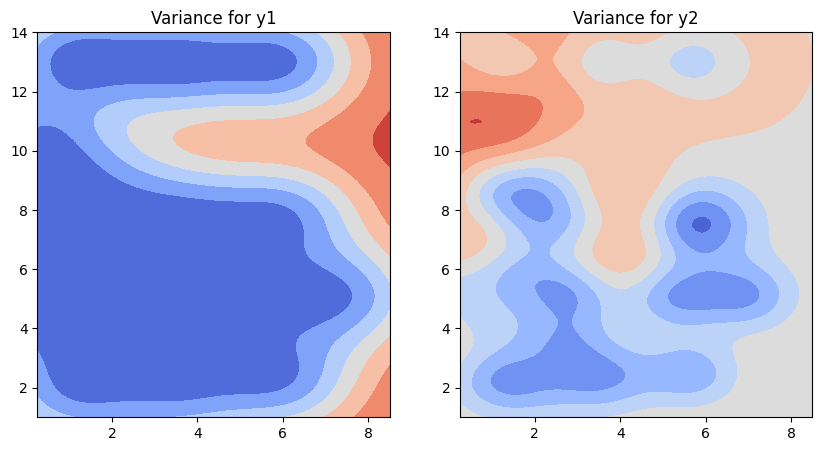

In [51]:
# Plot variance heatmaps to see if there's any variation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.contourf(x1_grid, x2_grid, f_var_y1, cmap='coolwarm')
plt.title("Variance for y1")

plt.subplot(1, 2, 2)
plt.contourf(x1_grid, x2_grid, f_var_y2, cmap='coolwarm')
plt.title("Variance for y2")

plt.show()

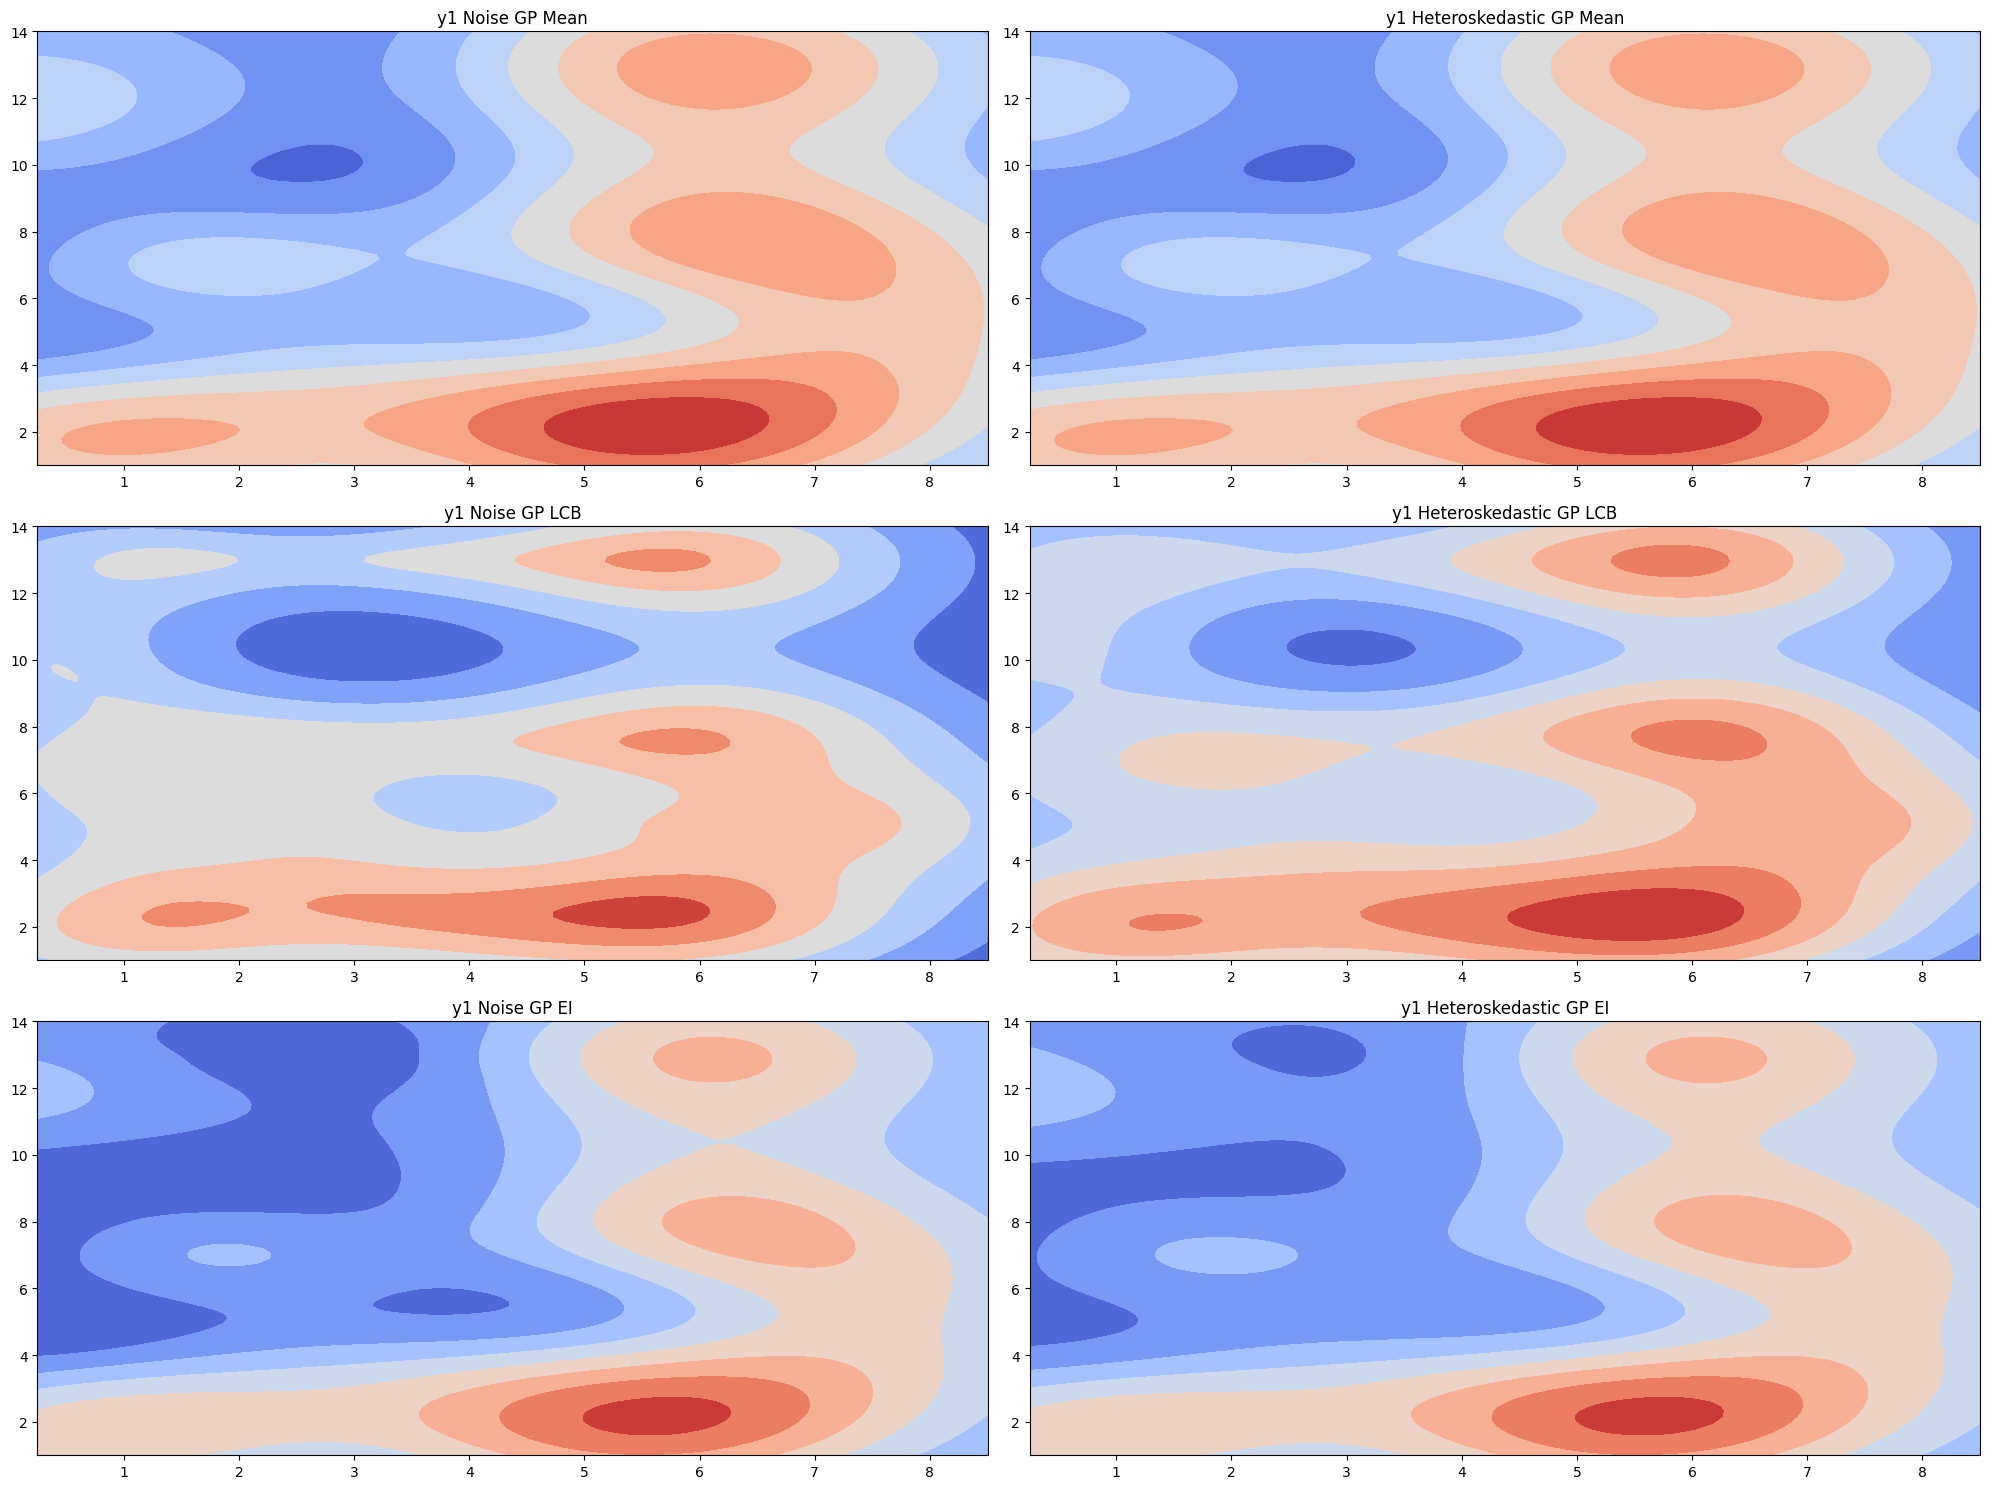

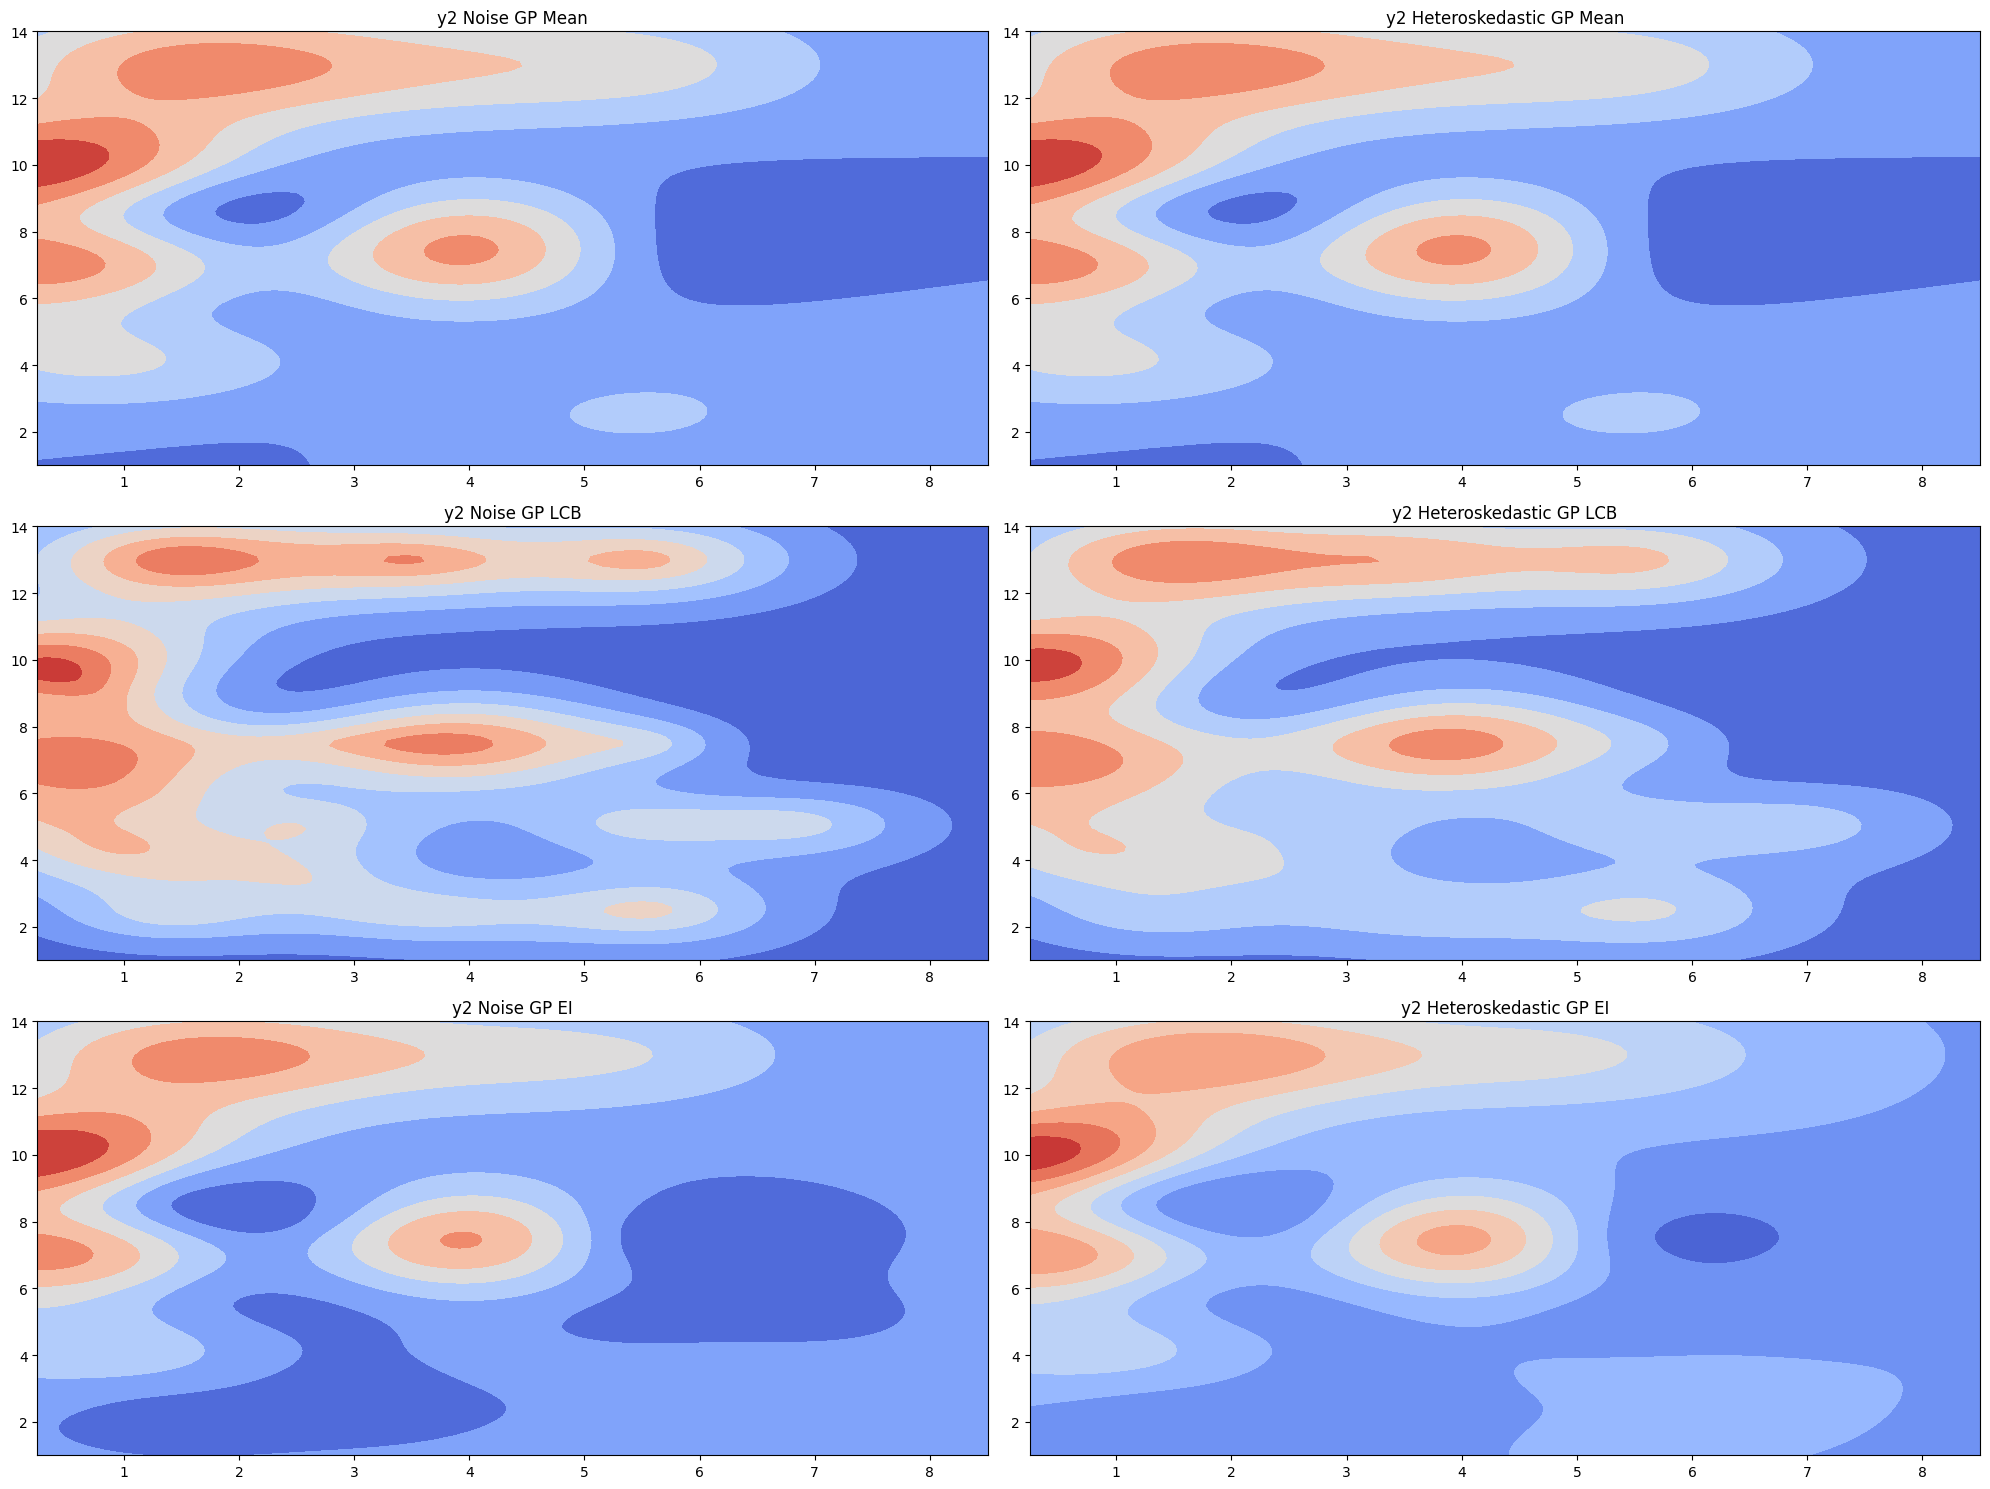

In [52]:
# Train noise GP model and heteroskedastic GP model for y1
noise_gp_model_y1 = train_noise_model(X, y1)
pred_noise_mean_y1, pred_noise_var_y1 = noise_gp_model_y1.predict_f(X_plot)
pred_noise_mean_y1 = pred_noise_mean_y1.numpy().reshape(x1_grid.shape)
pred_noise_var_y1 = pred_noise_var_y1.numpy().reshape(x1_grid.shape)

# Train heteroskedastic GP model for y1
heteroskedastic_gp_model_y1 = train_heteroskedastic_gp_model(X, y1, pred_noise_var_y1)
f_mean_y1, f_var_y1 = heteroskedastic_gp_model_y1.custom_predict(X_plot)
f_mean_y1 = f_mean_y1.numpy().reshape(x1_grid.shape)
f_var_y1 = f_var_y1.numpy().reshape(x1_grid.shape)

# Calculate LCB, UCB, and EI for noise GP and heteroskedastic GP for y1
LCB_noise_y1 = pred_noise_mean_y1 - 1.96 * np.sqrt(np.maximum(pred_noise_var_y1, 1e-9))
UCB_noise_y1 = pred_noise_mean_y1 + 1.96 * np.sqrt(np.maximum(pred_noise_var_y1, 1e-9))
EI_noise_y1 = expected_improvement(np.min(y1), pred_noise_mean_y1, pred_noise_var_y1)

LCB_y1 = f_mean_y1 - 1.96 * np.sqrt(np.maximum(f_var_y1, 1e-9))
UCB_y1 = f_mean_y1 + 1.96 * np.sqrt(np.maximum(f_var_y1, 1e-9))
EI_y1 = expected_improvement(np.min(y1), f_mean_y1, f_var_y1)

# Repeat for y2
noise_gp_model_y2 = train_noise_model(X, y2)
pred_noise_mean_y2, pred_noise_var_y2 = noise_gp_model_y2.predict_f(X_plot)
pred_noise_mean_y2 = pred_noise_mean_y2.numpy().reshape(x1_grid.shape)
pred_noise_var_y2 = pred_noise_var_y2.numpy().reshape(x1_grid.shape)

heteroskedastic_gp_model_y2 = train_heteroskedastic_gp_model(X, y2, pred_noise_var_y2)
f_mean_y2, f_var_y2 = heteroskedastic_gp_model_y2.custom_predict(X_plot)
f_mean_y2 = f_mean_y2.numpy().reshape(x1_grid.shape)
f_var_y2 = f_var_y2.numpy().reshape(x1_grid.shape)

LCB_noise_y2 = pred_noise_mean_y2 - 1.96 * np.sqrt(np.maximum(pred_noise_var_y2, 1e-9))
UCB_noise_y2 = pred_noise_mean_y2 + 1.96 * np.sqrt(np.maximum(pred_noise_var_y2, 1e-9))
EI_noise_y2 = expected_improvement(np.min(y2), pred_noise_mean_y2, pred_noise_var_y2)

LCB_y2 = f_mean_y2 - 1.96 * np.sqrt(np.maximum(f_var_y2, 1e-9))
UCB_y2 = f_mean_y2 + 1.96 * np.sqrt(np.maximum(f_var_y2, 1e-9))
EI_y2 = expected_improvement(np.min(y2), f_mean_y2, f_var_y2)

# Plot heatmaps to compare noise GP and heteroskedastic GP
def plot_comparison_heatmaps(x1_grid, x2_grid, noise_mean, noise_LCB, noise_EI, hetero_mean, hetero_LCB, hetero_EI, title_prefix):
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))

    # Noise GP plots
    axes[0, 0].contourf(x1_grid, x2_grid, noise_mean, cmap='coolwarm')
    axes[0, 0].set_title(f'{title_prefix} Noise GP Mean')
    axes[1, 0].contourf(x1_grid, x2_grid, noise_LCB, cmap='coolwarm')
    axes[1, 0].set_title(f'{title_prefix} Noise GP LCB')
    axes[2, 0].contourf(x1_grid, x2_grid, noise_EI, cmap='coolwarm')
    axes[2, 0].set_title(f'{title_prefix} Noise GP EI')

    # Heteroskedastic GP plots
    axes[0, 1].contourf(x1_grid, x2_grid, hetero_mean, cmap='coolwarm')
    axes[0, 1].set_title(f'{title_prefix} Heteroskedastic GP Mean')
    axes[1, 1].contourf(x1_grid, x2_grid, hetero_LCB, cmap='coolwarm')
    axes[1, 1].set_title(f'{title_prefix} Heteroskedastic GP LCB')
    axes[2, 1].contourf(x1_grid, x2_grid, hetero_EI, cmap='coolwarm')
    axes[2, 1].set_title(f'{title_prefix} Heteroskedastic GP EI')

    plt.tight_layout()
    plt.show()

# Plot comparison for y1
plot_comparison_heatmaps(x1_grid, x2_grid, pred_noise_mean_y1, LCB_noise_y1, EI_noise_y1, f_mean_y1, LCB_y1, EI_y1, "y1")

# Plot comparison for y2
plot_comparison_heatmaps(x1_grid, x2_grid, pred_noise_mean_y2, LCB_noise_y2, EI_noise_y2, f_mean_y2, LCB_y2, EI_y2, "y2")